# **Assignment 5 - Image Segmentation using UNET**

In this assignment we will apply our knowledge of convolutional neural networks and encoder-decoder architecture to perform image segmentation. Depending on whether you use Colab or the MAGIC server, your steps might be slightly different.

Image segmentation is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects. More precisely, it is the process of assigning a label to every pixel location in an image such that pixels with the same label share certain characteristics. Segmentation is of different types - simple image segmentation assigns a binary label to each pixel (foreground vs background), class-based segmentation (example image 1 below) will assign one of the object class labels (20 for PASCAL VOC 2012 as seen in class) or background (+1) and object-based segmentation (example image 2 below) will not only assign a class label to all objects of the same class in the scene but also, different labels if there are multiple instances of the same class in the image.

For this assignment, we will do simple image segmentation using a deep network which can easily be extended to the other two use cases.

![difference between class-based and object-based segmentation](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/Screenshot-from-2019-03-28-11-45-55.png)

# 0. Setup Colab

If you were able to view this in your browser in a nicely formmated way, you probably have Colab or MAGIC setup. If you are using Colab, reminder to connect it with your Google drive. If you are using any other machine, you can comment this out.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
!pwd
# you need to set this
path_to_your_project1_root_folder = 'My Drive/Colab Notebooks/content/segmentation'
os.chdir(f'/content/drive/{path_to_your_project1_root_folder}/data/')
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/My Drive/Colab Notebooks/content/segmentation/data
imagenet_class_index.json  images  masks  test.txt  train.txt  val.txt


# 1. Using CNNs for Classification - Review from Assignment 3

In assignment 3, you used Deep Convolutional Neural Networks such as RseNet-18 and VGG-16 for predicting class labels given an image. Your model was already trained on ImageNet dataset and its classes. This section is just a review of the same where we use a different network. You should be able to run this just to make sure you have all the installations and are ready to do the assignment.

In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset. More specifically, we will use a ResNet network containing 50 layers of depth as seen during class. The ILSVRC dataset where it was trained, contains a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model that comes with Pytorch and the vocabulary of categories.

In [ ]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
# !wget -nc http://www.cs.virginia.edu/~vicente/vision/2019/imagenet_class_index.json
!wget -nc https://www.cs.rice.edu/~vo9/vision/2019/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
#resnetModel = models.wide_resnet101_2(pretrained = True);
resnetModel = models.resnet50(pretrained = True);
resnetModel.eval();  # Set in evaluation mode! In this case it matters.
# Why? Batchnormalization layers behave differently during training
# than during evaluation time.

File ‘imagenet_class_index.json’ already there; not retrieving.



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now let's run an image through the network and get top 10 predictions. Pay careful attention to all the steps.

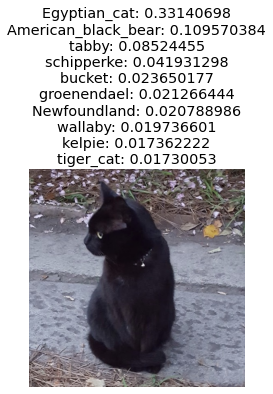

In [23]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This depends on the preprocessing faunction used during training. 
# It has to be the same preprocessing performed during training.
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# 3. Read image from URL into a PIL image type.
img_url = 'https://www.cs.rice.edu/~vo9/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  preprocessFn(img_pil).unsqueeze(0)
predictions = resnetModel(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

# 2. PyTorch on GPU

For the previous task and those in Assignment 3, you used CPU to run computations through the deep model to obtain your predictions. One of the reasons was that the model was already trained and you were not performing loss computation and backpropagation. As we deal with increasingly complex models, and their training and testing on larger datasets and image resolutions, we need to be efficient in computing matrix multiplications. 

In this section we will experiment with GPU computations and how they speed up some computations under certain conditions. We are going to test the GPU environment in a task of multiplying two square matrices of size  𝑑×𝑑 . We provide code below sample code and output for this part but you need to complete the test below. Note: It is possible that the first time you run the cell below, the CPU compute time is smaller than the GPU compute time. Why?

In [24]:
import torch
import time

# Let's create two matrices of size dxd.
d = 4000
a = torch.rand(d, d) # dxd matrix filled with random values.
b = torch.rand(d, d) # dxd matrix filled with random values.

# Compute a multiplication between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a multiplication between the two matrices in GPU.
start_time = time.time()
a = a.to('cuda') # Move to GPU.
b = b.to('cuda') # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 1.737937s


RuntimeError: ignored

If you a GPU is not available, you might get the following error:

```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-24-ddea0c42c3c6> in <module>
     15 # Compute a multiplication between the two matrices in GPU.
     16 start_time = time.time()
---> 17 a = a.to('cuda') # Move to GPU.
     18 b = b.to('cuda') # Move to GPU.
     19 output = torch.mm(a,b)  # Multiplication happens in GPU.

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py in _lazy_init()
    215         # This function throws if there's a driver initialization error, no GPUs
    216         # are found or any other error occurs
--> 217         torch._C._cuda_init()
    218         # Some of the queued calls may reentrantly call _lazy_init();
    219         # we need to just return without initializing in that case.

RuntimeError: No CUDA GPUs are available
```

No need to worry, you can proceed to the next step.

**Final Comments:** There is a more or less fixed cost of moving tensors to the GPU, the effect is that using GPUs for small tensors is actually counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.

# 3. Download and prepare the segmentation dataset

For training and testing our segmentation network, we are going to use the PASCAL VOC 2007 dataset: [link text](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html)

The dataset is used for multiple tasks, but we will only use the part relevant to segmentation. The subset of the dataset has been shared with you on google drive: https://drive.google.com/drive/folders/1xGqWwVtg0Wj9PBkAst_9zwr2qo0TD_Aw?usp=sharing

If you check the masks, they have different colors for differen classes, don't worry about it. We will convert all masks to binary to perform simple image segmentation.

Before we use the dataset, we will setup some parameters.



In [25]:
# import the necessary packages
import torch
import os
# base path of the dataset ----- you will need to set this ----------
# DATASET_PATH = os.path.join("data", "VOC2007")
DATASET_PATH = os.getcwd()
print(DATASET_PATH)

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# train, val, and test file paths
TRAIN_FILE_PATH = os.path.join(DATASET_PATH, "train.txt")
VAL_FILE_PATH = os.path.join(DATASET_PATH, "val.txt")
TEST_FILE_PATH = os.path.join(DATASET_PATH, "test.txt")

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 224
INPUT_IMAGE_HEIGHT = 224

# define threshold to filter weak predictions
THRESHOLD = 0.1

# define the path to the base output directory
folders = os.getcwd().split('/')[:-1]
BASE_OUTPUT = os.path.join("/".join(folders), "output") ----- you will need to set this ----------
print(BASE_OUTPUT)
# define the path to the output serialized model, model training
# plot
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_voc.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])


/content/drive/MyDrive/Colab Notebooks/content/segmentation/data
/content/drive/MyDrive/Colab Notebooks/content/segmentation/output


### Creating the dataset object using torch. Each instance contains one image and it's binarized segmentation mask.

In [26]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, itransforms, mtransforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.itransforms = itransforms
		self.mtransforms = mtransforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
  
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		# print(imagePath, self.maskPaths[idx])
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		th, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
		# check to see if we are applying any transformations
		if self.itransforms is not None:
			# apply the transformations to both image and its mask
			image = self.itransforms(image)
			mask = self.mtransforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

# 4. Defining the Model Architecture

We are going to use the U-Net architecture which we have seen in class. The schematic diagram of the architecture is below. 

![](https://929687.smushcdn.com/2633864/wp-content/uploads/2021/11/unet_small.png?lossy=1&strip=1&webp=1)

The architecture has been created for you below. Instead of two-channel output masks, the implemented model will only output a single-channel mask with predictions between 0 and 1 for each pixel location.

In [27]:
# import the necessary packages

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
  
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize	
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

# 5. Training the Model

We have defined the dataset and its instances and the network. In the next step, we need to train the network. 

In [1]:
# USAGE
# python train.py
# import the necessary packages
# from pyimagesearch.dataset import SegmentationDataset
# from pyimagesearch.model import UNet
# from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

trainImages = []
trainMasks = []

# load training images and mask filepaths into trainImages and trainMasks ----- read train.txt file provided with the dataset
#
#
#
#
#
	
valImages = []
valMasks = []

# load validation images and mask filepaths into valImages and valMasks ----- read val.txt file provided with the dataset
#
#
#
#
#
	
testImages = []
testMasks = []

# load testing image and mask filepaths into testImages and testMasks ----- read train.txt file provided with the dataset
#
#
#
#
#


# define transformations
itransforms = transforms.Compose(
    [transforms.ToPILImage(),
		 transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

mtransforms = transforms.Compose(
		[transforms.ToPILImage(),
		 transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor()]
)

# create the train, validation and test datasets
trainDS = SegmentationDataset(imagePaths=sorted(trainImages), maskPaths=sorted(trainMasks),
	  itransforms=itransforms, mtransforms=mtransforms)
valDS = SegmentationDataset(imagePaths=sorted(valImages), maskPaths=sorted(valMasks),
    itransforms=itransforms, mtransforms=mtransforms)
testDS = SegmentationDataset(imagePaths=sorted(testImages), maskPaths=sorted(testMasks),
    itransforms=itransforms, mtransforms=mtransforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the val set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")


# create the training, validation data loaders ---- trainLoader, valLoader -------


# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}


# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss

    # switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in valLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalValLoss += lossFunc(pred, y)
	# calculate the average training and validation loss ---- avgTrainLoss and avgValLoss--------
	#
	#

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	
	
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgValLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and label the axes and add a legend.
plt.style.use("ggplot")
plt.figure()
# 
# 
# 
# 
# 
# 
plt.savefig(PLOT_PATH)


# serialize the model to disk
torch.save(unet, MODEL_PATH)

NameError: ignored

# 6. Evaluation on Test Images - Qualitative

Here we will visualize the input image, its ground truth mask and the mask predicted by the trained network.

[INFO] loading up test image paths...
[INFO] load up model...


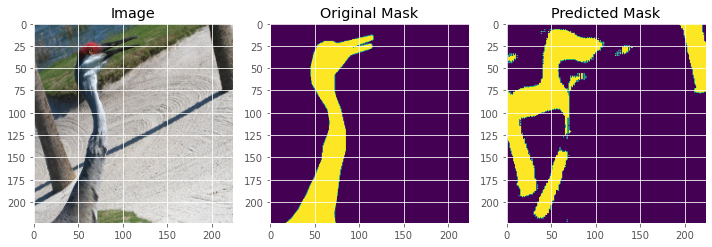

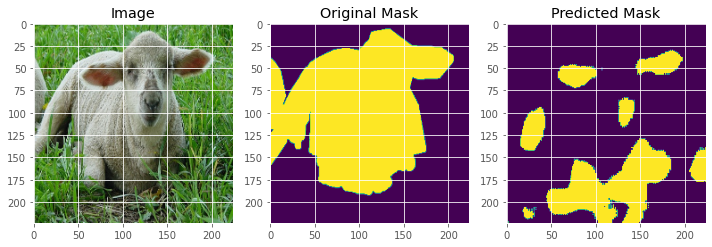

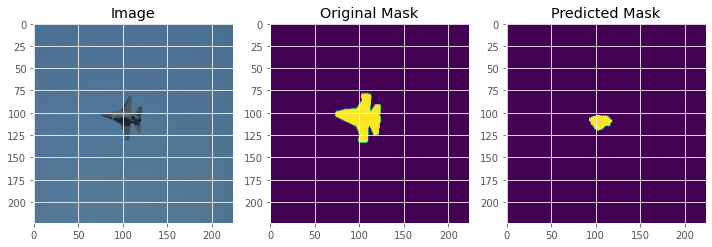

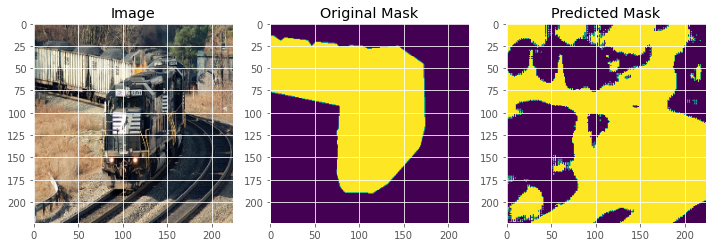

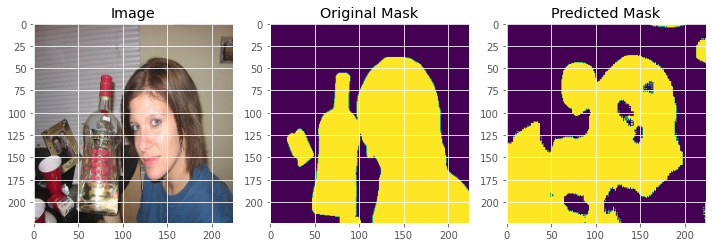

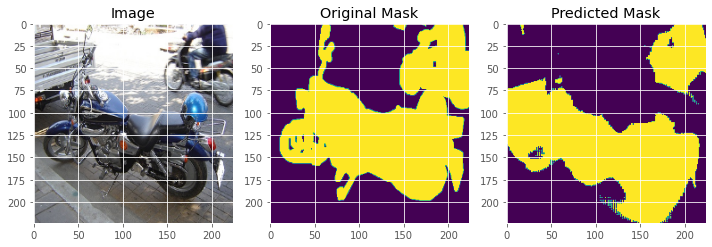

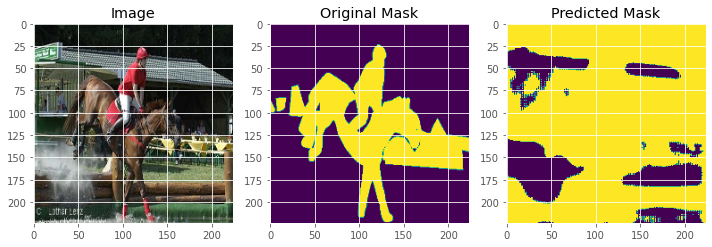

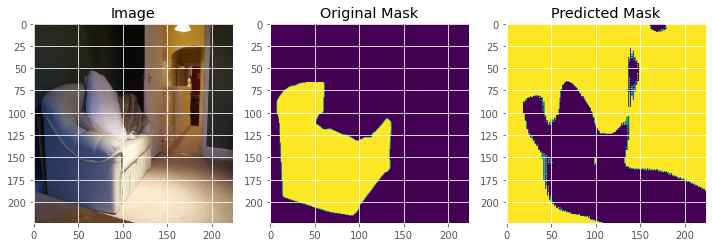

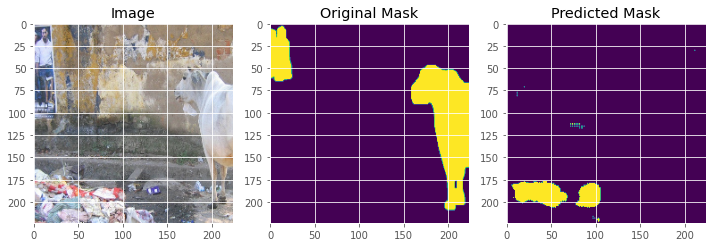

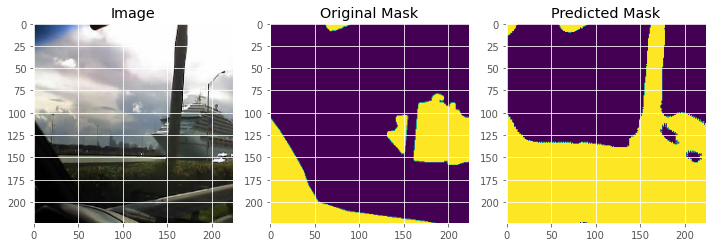

In [29]:
# import the necessary packages
# from pyimagesearch import config
# torch.save(unet, MODEL_PATH)
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
 
def make_predictions(model, imagePath, groundTruthPath):
	# set model to evaluation mode -------- important ---------
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (256, 256))
		center = image.shape
		x = center[1]/2 - 112
		y = center[0]/2 - 112

		crop_img = image[int(y):int(y+224), int(x):int(x+224)]
		orig = crop_img.copy()
		
		# load the ground-truth segmentation mask and binarize it
		# then resize it to 256x256 and obtain a cntercrop of 224x224. ------ this has to be the same as the preprocessing done for training-----
		#
		#
		#
		#
		#
    
    # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
	
		# filter out the weak predictions and convert them to integers in the next two lines ------(threshold and convert them to uint8)---------
		#
		#
		# prepare a plot for visualization
		prepare_plot(orig, crop_mask, predMask)
  

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the test image paths
for path, maskpath in zip(testImages[:10], testMasks[:10]): ### ----- change this to randomly select 10 images to test ------
	# make predictions and visualize the results
	make_predictions(unet, path, maskpath)

### 7. Quantitative Evaluation

Select 100 random images from the test set. Record the image IDs in a text file. Run predictions for these 100 images and calculate the mean IoU.